In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/pytorch")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")

from turing.three_nodes_circuits import create_circuit_3954
from pde_solvers.cn import RD_2D_1st_Order, Neumann_Boundary_2D, Diritchlet_Boundary_2D,Periodic_Boundary_2D

from local_utils import *

from intro import *
from scipy.optimize import minimize

import pandas as pd

In [2]:
def p(* args):
    plot_n_im(args, 
           [chr(ord('A') + i) for i in range(28)][:len(args)],          
        figsize=(10, 4), shrink=.7); plt.tight_layout();plt.show()

In [3]:
def create_F_A(A,B,C):
    def F_A(b_A, mu_A, V_A,
            K_AA, K_BA, n_AA, n_BA, **kwargs):
        fA_v = b_A + V_A * act(A, K_AA, n_AA) * inh(B, K_BA, n_BA) - mu_A * A        
        return fA_v
    return F_A
def create_F_B(A,B,C):
    def F_B(b_B, mu_B, V_B,
            K_AB, K_CB, n_AB, n_CB, **kwargs):
        fB_v = b_B + V_B * act(A, K_AB, n_AB) * inh(C, K_CB, n_CB) - mu_B * B
        return fB_v
    return F_B
def create_F_C(A,B,C):
    def F_C(b_C, mu_C, V_C,
            K_AC, K_BC, K_CC, n_AC, n_BC, n_CC, **kwargs):
        fC_v = b_C + V_C * inh(A, K_AC, n_AC) * inh(B, K_BC, n_BC) * act(C, K_CC, n_CC) - mu_C * C        
        return fC_v
    return F_C

def create_param_kinetics(A,B,C):
    F_A = create_F_A(A,B,C)
    F_B = create_F_B(A,B,C)
    F_C = create_F_C(A,B,C)
    def circuit_3954(b_A, mu_A, V_A,
                     K_AA, K_AB, K_AC, 
                     b_B, mu_B, V_B, 
                     K_BA, K_BC, 
                     b_C, mu_C, V_C, 
                     K_CB, K_CC, 
                     n_AA, n_BA,
                     n_AB, n_CB,
                     n_AC, n_BC, n_CC,
                     **kwargs):
        fA_v = F_A(b_A, mu_A, V_A, K_AA, K_BA, n_AA, n_BA)
        fB_v = F_B(b_B, mu_B, V_B, K_AB, K_CB, n_AB, n_CB)
        fC_v = F_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC)
        return (fA_v, fB_v, fC_v)
    return circuit_3954

In [4]:
params_A_name_list = ["b_A", "\mu_A", "V_A","K_{AA}", "K_{BA}","n_{AA}", "n_{BA}"]
params_B_name_list = ["b_B", "\mu_B", "V_B","K_{AB}", "K_{CB}","n_{AB}", "n_{CB}"]
params_C_name_list = ["b_C", "\mu_C", "V_C","K_{AC}", "K_{BC}", "K_{CC}","n_{AC}", "n_{BC}", "n_{CC}"]

In [5]:
import pickle
with open(f"./inputs/solution_3.pkl", "rb") as f:
    (run_params, params, solution) = pickle.load(f)
    
    
run_params = Struct(**run_params)
params = Struct(**params)

In [19]:
import pickle
def load_and_plot(file_path):
    with open(file_path, "rb") as f:
        (run_params, params, solution) = pickle.load(f)
    run_params = Struct(**run_params)
    params = Struct(**params)
    #########################################
    index = -1#5000#-2#200000-1#3000#5000-1
    A_n = solution[index,0, :].reshape((128,128))
    B_n = solution[index,1, :].reshape((128,128))
    C_n = solution[index,2, :].reshape((128,128))

    x_slice = y_slice = slice(1,-1,1)

    diff_c = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
    diffusion_A_n = diff_c * grad_diff(A_n)[x_slice,y_slice, np.newaxis, np.newaxis]
    diffusion_B_n = diff_c * grad_diff(B_n)[x_slice,y_slice, np.newaxis, np.newaxis]


    param_F_A = create_F_A(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])
    param_F_B = create_F_B(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])
    param_F_C = create_F_C(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])

    D_A, D_B = params["D_A"], params["D_B"]

    def time_der_A(b_A, mu_A, V_A,
                   K_AA, K_BA, n_AA, n_BA, **kwargs):

        F_A = param_F_A(b_A, mu_A, V_A, K_AA, K_BA, n_AA, n_BA)    
        dAdt = D_A*diffusion_A_n + F_A[x_slice,y_slice, :, :]    
        return dAdt

    def time_der_B(b_B, mu_B, V_B,
                   K_AB, K_CB, n_AB, n_CB, **kwargs):

        F_B = param_F_B(b_B, mu_B, V_B, K_AB, K_CB, n_AB, n_CB)
        dBdt = D_B*diffusion_B_n + F_B[x_slice,y_slice, :, :]    
        return dBdt

    def time_der_C(b_C, mu_C, V_C,
                   K_AC, K_BC, K_CC, n_AC, n_BC, n_CC, **kwargs):

        dCdt = param_F_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC)[x_slice,y_slice, :, :] 
        return dCdt

    def time_derivatives(b_A, mu_A, V_A,
                         K_AA, K_AB, K_AC, 
                         b_B, mu_B, V_B, 
                         K_BA, K_BC, 
                         b_C, mu_C, V_C, 
                         K_CB, K_CC, 
                         n_AA, n_BA,
                         n_AB, n_CB,
                         n_AC, n_BC, n_CC,
                         **kwargs):

        dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA, n_AA, n_BA)
        dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB, n_AB, n_CB)
        dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC)
        return dAdt, dBdt, dCdt

    def loss_A(b_A, mu_A, V_A,K_AA, K_BA, n_AA, n_BA,  **kwargs):
        dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA, n_AA, n_BA)  
        return np.mean(dAdt**2, axis=(0,1))

    def loss_B(b_B, mu_B, V_B,K_AB, K_CB, n_AB, n_CB,  **kwargs):
        dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB, n_AB, n_CB)
        return np.mean(dBdt**2, axis=(0,1))

    def loss_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC,  **kwargs):
        dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC)
        return np.mean(dCdt**2, axis=(0,1))
    #################################
    p(A_n, B_n, C_n)
    #################################
    def plot_single_minimum_by_sacle(original_params, L2_func, direction, index, 
                                     scale=1.0, label=""):
        sample_points_num = 400 + 1
        par = original_params[index]    
        steps = np.linspace(-par, par, sample_points_num)*scale
        test_points = directional_linspace(original_params, direction, steps)    
        plt.plot(test_points[:, index], 
                [L2_func(*p).squeeze() for p in  test_points], 
                label=r"$" f"{label}" r"$",
                color='black')    
        origin_test_index = (sample_points_num-1)//2
        original_point = test_points[origin_test_index, index]
        original_loss = L2_func(*test_points[origin_test_index, :]).squeeze()
        plt.scatter(original_point,
                    original_loss,
                    s=60,
                    c='red',
                    marker='x')
    ###############################
    original_A_params = np.array([params.b_A, params.mu_A, params.V_A, 
                                   params.K_AA, params.K_BA, params.n, params.n])

    original_B_params = np.array([params.b_B, params.mu_B, params.V_B, 
                                   params.K_AB, params.K_CB, params.n, params.n])

    original_C_params = np.array([params.b_C, params.mu_C, params.V_C, 
                                   params.K_AC, params.K_BC, params.K_CC, params.n, params.n, params.n])

    def plot_fixed_params(index, original_params, loss, params_name, scale=1.5):

        direction= np.zeros_like(original_params)
        direction[index] = 1
        name = params_name[index]
        plot_single_minimum_by_sacle(original_params, 
                                    loss, direction,
                                    index, scale, name)
        plt.xticks(rotation=45);plt.grid();plt.legend()
        plt.xlabel(r"$" f"{name}" "$");plt.ylabel("Loss");plt.yscale("log");
    print("-------------------------------------")
    print("          A")
    _ = plt.figure(figsize=(10,20))
    for i in range(7):
        ax = plt.subplot(7,1,i+1)
        plot_fixed_params(i, original_A_params, loss_A, params_A_name_list)
    plt.tight_layout();plt.show()
    print("-------------------------------------")
    print("          B")
    _ = plt.figure(figsize=(10,20))
    for i in range(7):
        ax = plt.subplot(7,1,i+1)
        plot_fixed_params(i, original_B_params, loss_B, params_B_name_list)
    plt.tight_layout();plt.show()
    print("-------------------------------------")
    print("          C")
    _ = plt.figure(figsize=(10,26))
    for i in range(9):
        ax = plt.subplot(9,1,i+1)
        plot_fixed_params(i, original_C_params, loss_C, params_C_name_list)
    plt.tight_layout();plt.show()


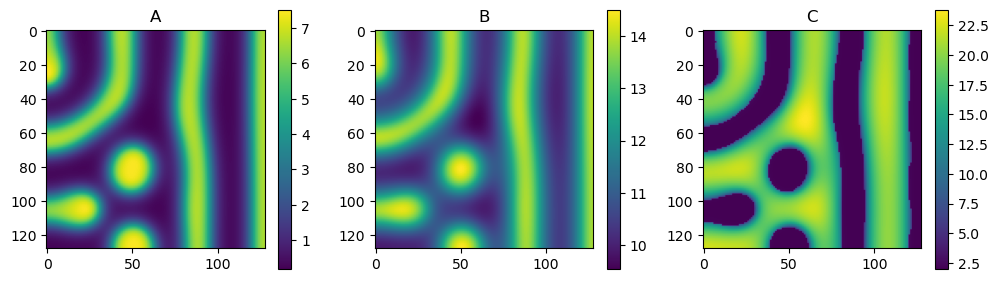

-------------------------------------
          A


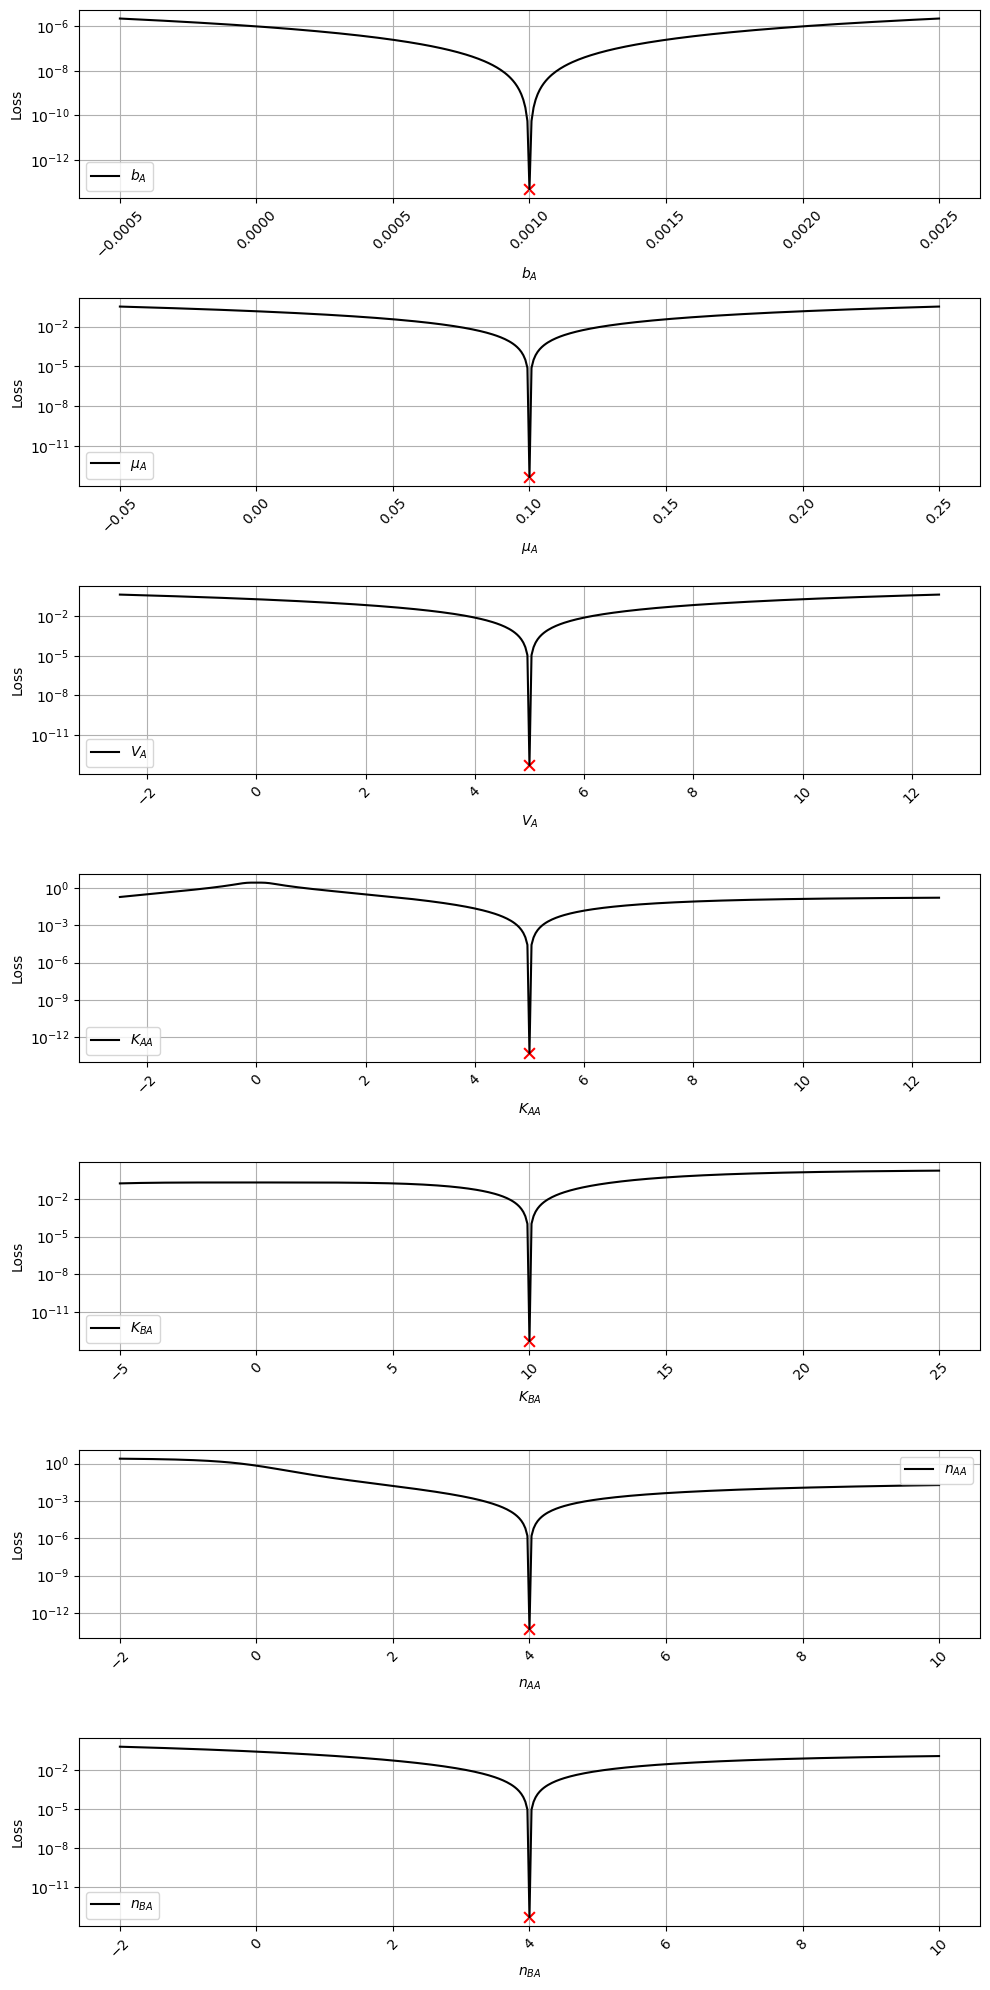

-------------------------------------
          B


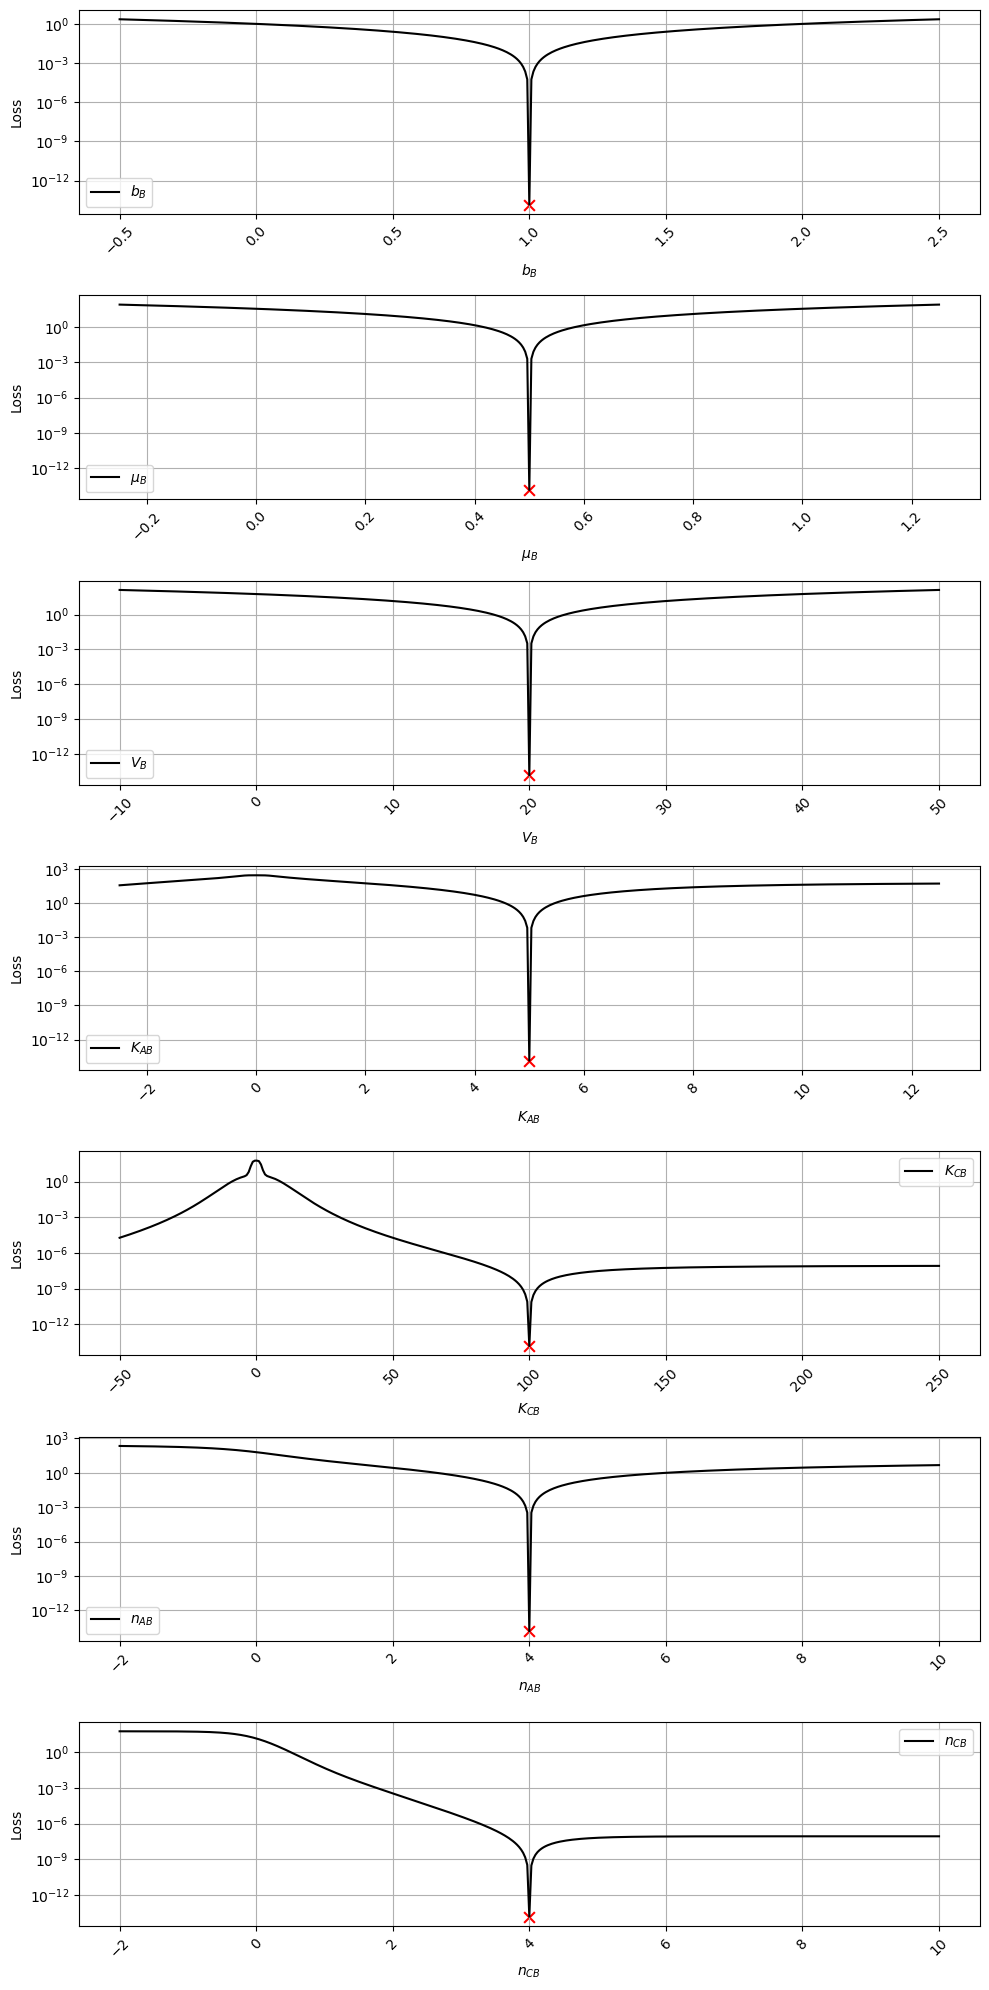

-------------------------------------
          C


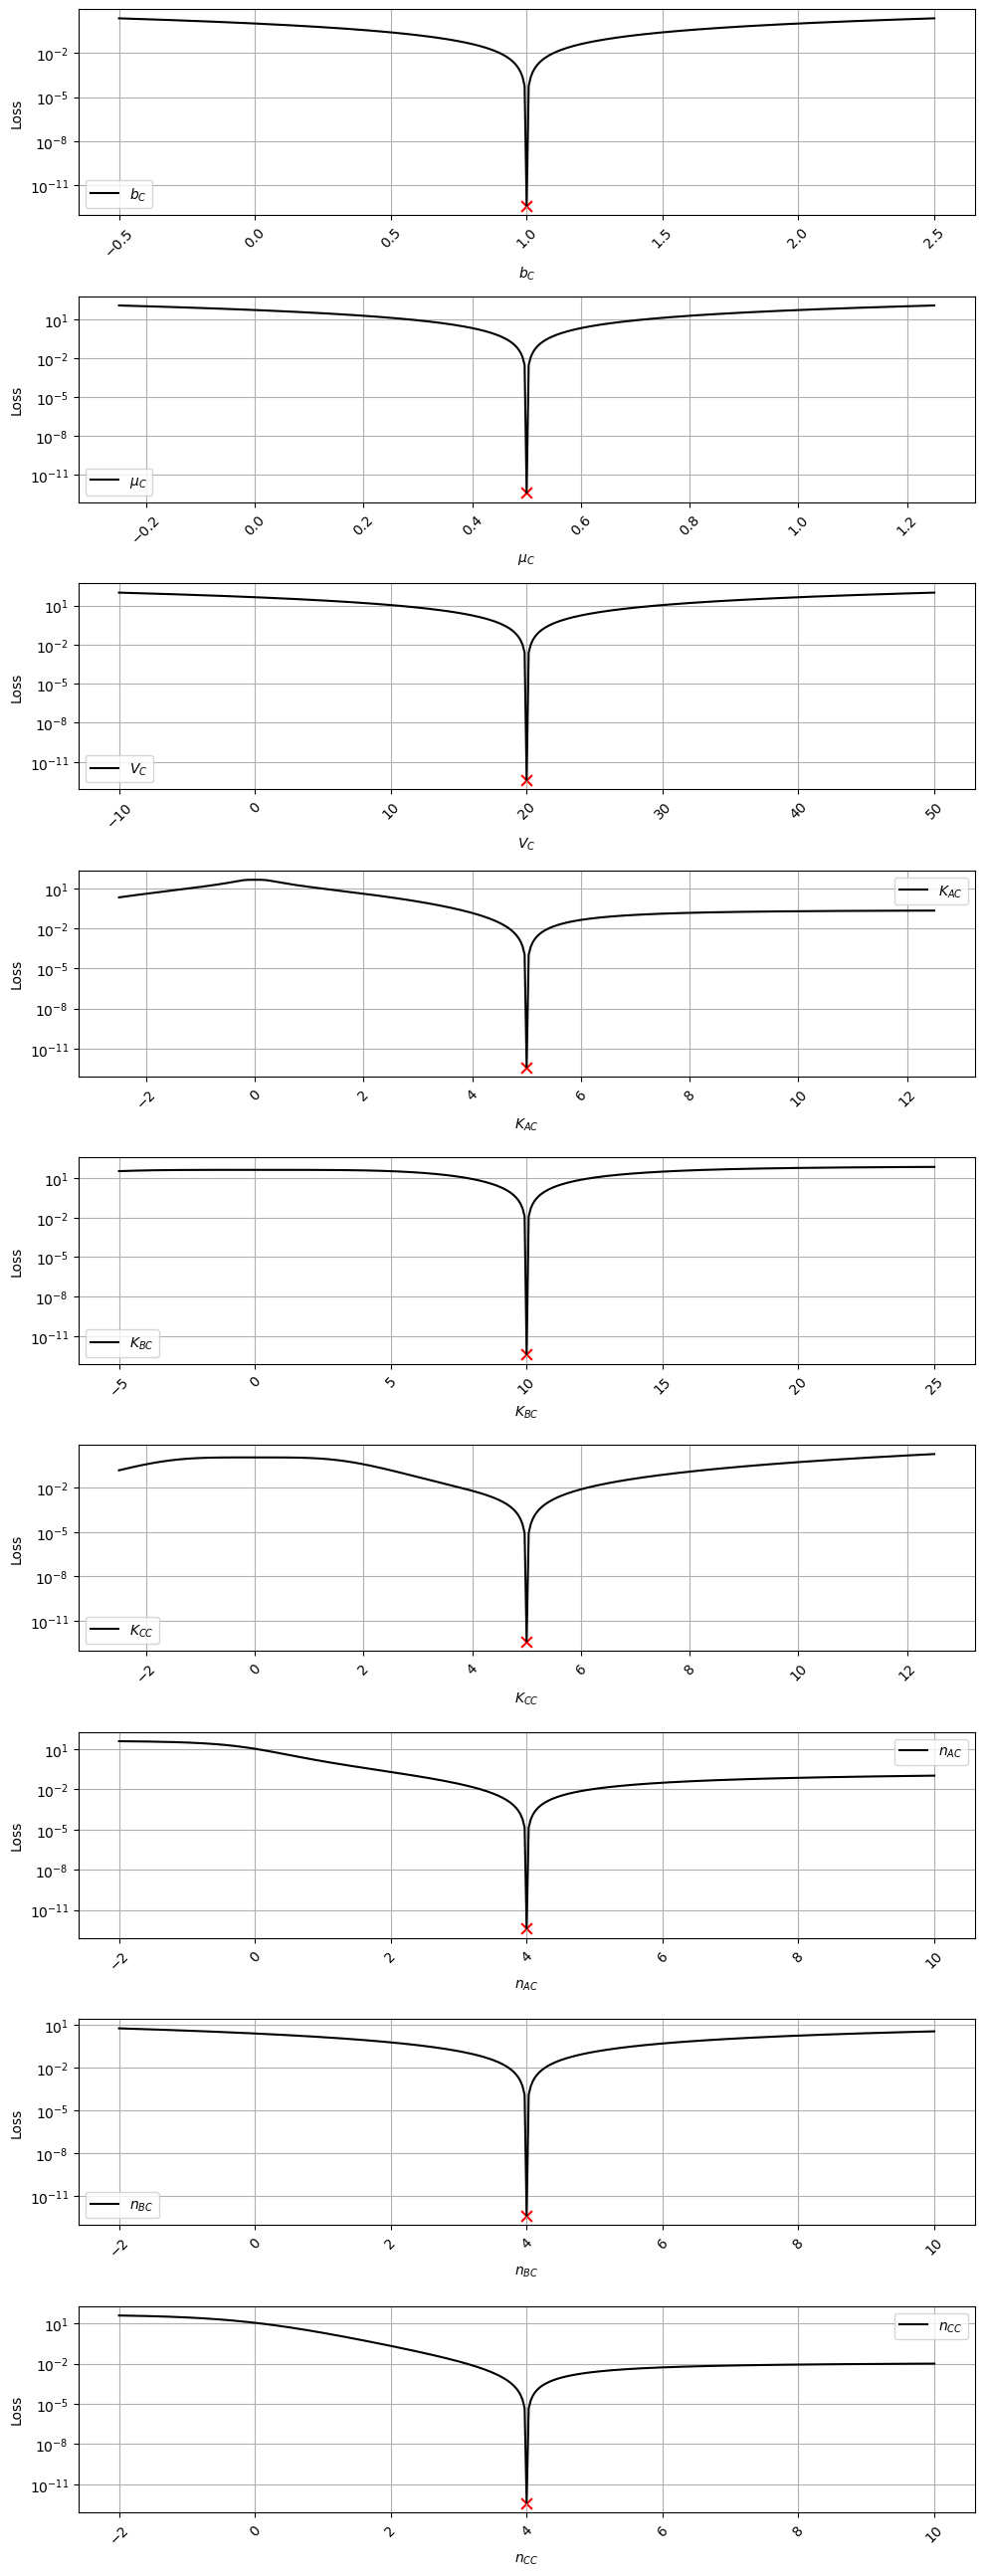

In [20]:
load_and_plot(f"./inputs/solution_3.pkl")

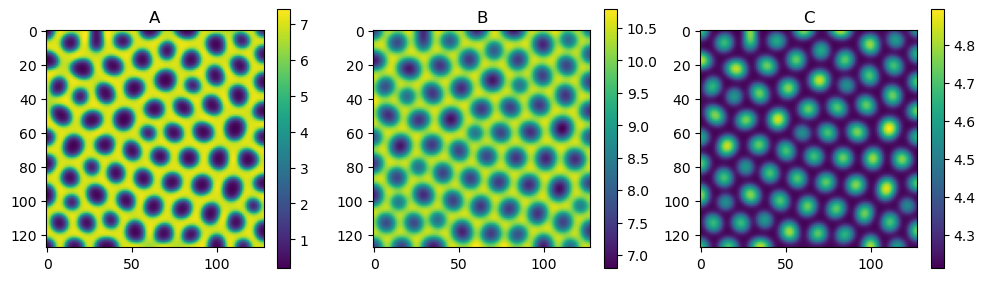

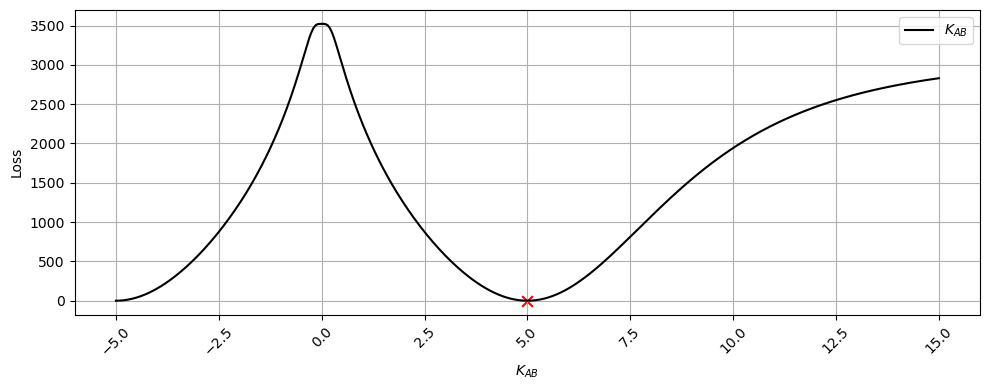

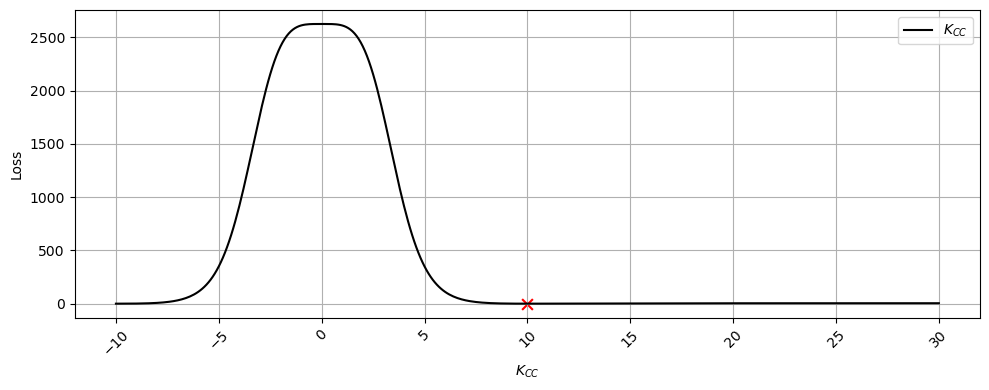

In [21]:
file_path = f"./inputs/solution_14.pkl"
with open(file_path, "rb") as f:
    (run_params, params, solution) = pickle.load(f)
run_params = Struct(**run_params)
params = Struct(**params)
#########################################
index = -1#5000#-2#200000-1#3000#5000-1
A_n = solution[index,0, :].reshape((128,128))
B_n = solution[index,1, :].reshape((128,128))
C_n = solution[index,2, :].reshape((128,128))

x_slice = y_slice = slice(1,-1,1)

diff_c = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
diffusion_A_n = diff_c * grad_diff(A_n)[x_slice,y_slice, np.newaxis, np.newaxis]
diffusion_B_n = diff_c * grad_diff(B_n)[x_slice,y_slice, np.newaxis, np.newaxis]


param_F_A = create_F_A(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])
param_F_B = create_F_B(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])
param_F_C = create_F_C(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])

D_A, D_B = params["D_A"], params["D_B"]

def time_der_A(b_A, mu_A, V_A,
               K_AA, K_BA, n_AA, n_BA, **kwargs):

    F_A = param_F_A(b_A, mu_A, V_A, K_AA, K_BA, n_AA, n_BA)    
    dAdt = D_A*diffusion_A_n + F_A[x_slice,y_slice, :, :]    
    return dAdt

def time_der_B(b_B, mu_B, V_B,
               K_AB, K_CB, n_AB, n_CB, **kwargs):

    F_B = param_F_B(b_B, mu_B, V_B, K_AB, K_CB, n_AB, n_CB)
    dBdt = D_B*diffusion_B_n + F_B[x_slice,y_slice, :, :]    
    return dBdt

def time_der_C(b_C, mu_C, V_C,
               K_AC, K_BC, K_CC, n_AC, n_BC, n_CC, **kwargs):

    dCdt = param_F_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC)[x_slice,y_slice, :, :] 
    return dCdt

def time_derivatives(b_A, mu_A, V_A,
                     K_AA, K_AB, K_AC, 
                     b_B, mu_B, V_B, 
                     K_BA, K_BC, 
                     b_C, mu_C, V_C, 
                     K_CB, K_CC, 
                     n_AA, n_BA,
                     n_AB, n_CB,
                     n_AC, n_BC, n_CC,
                     **kwargs):

    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA, n_AA, n_BA)
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB, n_AB, n_CB)
    dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC)
    return dAdt, dBdt, dCdt

def loss_A(b_A, mu_A, V_A,K_AA, K_BA, n_AA, n_BA,  **kwargs):
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA, n_AA, n_BA)  
    return np.mean(dAdt**2, axis=(0,1))

def loss_B(b_B, mu_B, V_B,K_AB, K_CB, n_AB, n_CB,  **kwargs):
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB, n_AB, n_CB)
    return np.mean(dBdt**2, axis=(0,1))

def loss_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC,  **kwargs):
    dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC)
    return np.mean(dCdt**2, axis=(0,1))
#################################
p(A_n, B_n, C_n)
#################################
def plot_single_minimum_by_sacle(original_params, L2_func, direction, index, 
                                 scale=1.0, label=""):
    sample_points_num = 400 + 1
    par = original_params[index]    
    steps = np.linspace(-par, par, sample_points_num)*scale
    test_points = directional_linspace(original_params, direction, steps)    
    plt.plot(test_points[:, index], 
            [L2_func(*p).squeeze() for p in  test_points], 
            label=r"$" f"{label}" r"$",
            color='black')    
    origin_test_index = (sample_points_num-1)//2
    original_point = test_points[origin_test_index, index]
    original_loss = L2_func(*test_points[origin_test_index, :]).squeeze()
    plt.scatter(original_point,
                original_loss,
                s=60,
                c='red',
                marker='x')
###############################
original_A_params = np.array([params.b_A, params.mu_A, params.V_A, 
                               params.K_AA, params.K_BA, params.n, params.n])

original_B_params = np.array([params.b_B, params.mu_B, params.V_B, 
                               params.K_AB, params.K_CB, params.n, params.n])

original_C_params = np.array([params.b_C, params.mu_C, params.V_C, 
                               params.K_AC, params.K_BC, params.K_CC, params.n, params.n, params.n])

def plot_fixed_params(index, original_params, loss, params_name, scale=1.5):

    direction= np.zeros_like(original_params)
    direction[index] = 1
    name = params_name[index]
    plot_single_minimum_by_sacle(original_params, 
                                loss, direction,
                                index, scale, name)
    plt.xticks(rotation=45);plt.grid();plt.legend()
    plt.xlabel(r"$" f"{name}" "$");plt.ylabel("Loss");#plt.yscale("log");
        
_ = plt.figure(figsize=(10,4))
plot_fixed_params(3, original_B_params, loss_B, params_B_name_list, scale=2)
plt.tight_layout();plt.show()
_ = plt.figure(figsize=(10,4))
plot_fixed_params(5, original_C_params, loss_C, params_C_name_list, scale=2)
plt.tight_layout();plt.show()


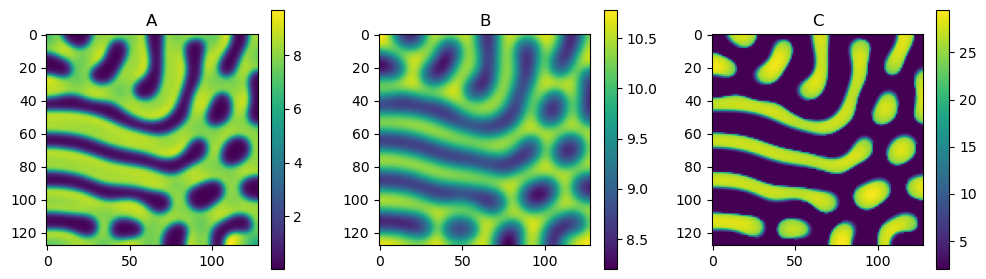

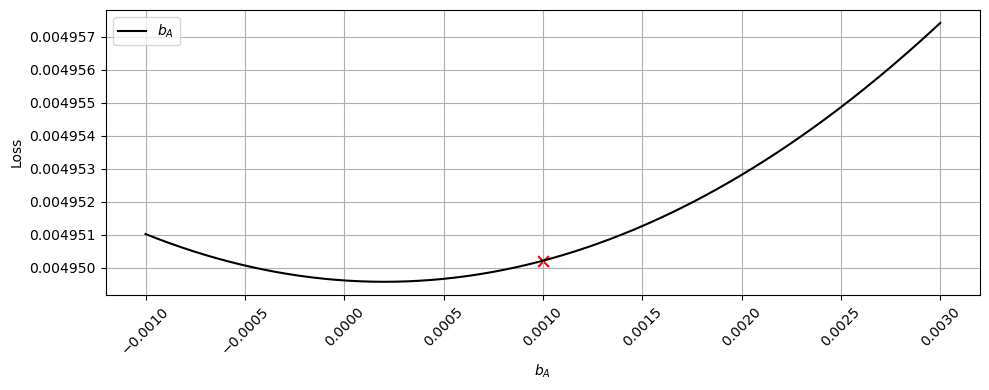

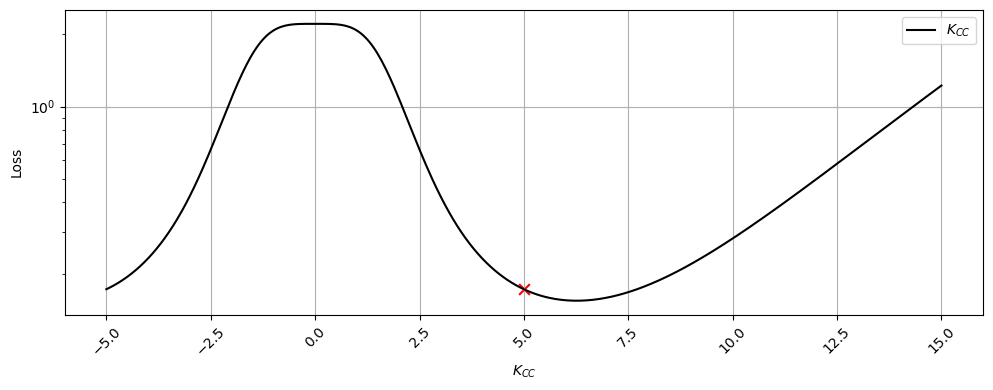

In [22]:
file_path = f"./inputs/solution_24.pkl"
with open(file_path, "rb") as f:
    (run_params, params, solution) = pickle.load(f)
run_params = Struct(**run_params)
params = Struct(**params)
#########################################
index = -1#5000#-2#200000-1#3000#5000-1
A_n = solution[index,0, :].reshape((128,128))
B_n = solution[index,1, :].reshape((128,128))
C_n = solution[index,2, :].reshape((128,128))

x_slice = y_slice = slice(1,-1,1)

diff_c = (run_params.Ix-1)*(run_params.Jy-1)/(run_params.Lx*run_params.Ly)
diffusion_A_n = diff_c * grad_diff(A_n)[x_slice,y_slice, np.newaxis, np.newaxis]
diffusion_B_n = diff_c * grad_diff(B_n)[x_slice,y_slice, np.newaxis, np.newaxis]


param_F_A = create_F_A(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])
param_F_B = create_F_B(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])
param_F_C = create_F_C(A_n[:,:, np.newaxis, np.newaxis], B_n[:,:, np.newaxis, np.newaxis], C_n[:,:, np.newaxis, np.newaxis])

D_A, D_B = params["D_A"], params["D_B"]

def time_der_A(b_A, mu_A, V_A,
               K_AA, K_BA, n_AA, n_BA, **kwargs):

    F_A = param_F_A(b_A, mu_A, V_A, K_AA, K_BA, n_AA, n_BA)    
    dAdt = D_A*diffusion_A_n + F_A[x_slice,y_slice, :, :]    
    return dAdt

def time_der_B(b_B, mu_B, V_B,
               K_AB, K_CB, n_AB, n_CB, **kwargs):

    F_B = param_F_B(b_B, mu_B, V_B, K_AB, K_CB, n_AB, n_CB)
    dBdt = D_B*diffusion_B_n + F_B[x_slice,y_slice, :, :]    
    return dBdt

def time_der_C(b_C, mu_C, V_C,
               K_AC, K_BC, K_CC, n_AC, n_BC, n_CC, **kwargs):

    dCdt = param_F_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC)[x_slice,y_slice, :, :] 
    return dCdt

def time_derivatives(b_A, mu_A, V_A,
                     K_AA, K_AB, K_AC, 
                     b_B, mu_B, V_B, 
                     K_BA, K_BC, 
                     b_C, mu_C, V_C, 
                     K_CB, K_CC, 
                     n_AA, n_BA,
                     n_AB, n_CB,
                     n_AC, n_BC, n_CC,
                     **kwargs):

    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA, n_AA, n_BA)
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB, n_AB, n_CB)
    dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC)
    return dAdt, dBdt, dCdt

def loss_A(b_A, mu_A, V_A,K_AA, K_BA, n_AA, n_BA,  **kwargs):
    dAdt = time_der_A(b_A, mu_A, V_A, K_AA, K_BA, n_AA, n_BA)  
    return np.mean(dAdt**2, axis=(0,1))

def loss_B(b_B, mu_B, V_B,K_AB, K_CB, n_AB, n_CB,  **kwargs):
    dBdt = time_der_B(b_B, mu_B, V_B, K_AB, K_CB, n_AB, n_CB)
    return np.mean(dBdt**2, axis=(0,1))

def loss_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC,  **kwargs):
    dCdt = time_der_C(b_C, mu_C, V_C, K_AC, K_BC, K_CC, n_AC, n_BC, n_CC)
    return np.mean(dCdt**2, axis=(0,1))
#################################
p(A_n, B_n, C_n)
#################################
def plot_single_minimum_by_sacle(original_params, L2_func, direction, index, 
                                 scale=1.0, label=""):
    sample_points_num = 400 + 1
    par = original_params[index]    
    steps = np.linspace(-par, par, sample_points_num)*scale
    test_points = directional_linspace(original_params, direction, steps)    
    plt.plot(test_points[:, index], 
            [L2_func(*p).squeeze() for p in  test_points], 
            label=r"$" f"{label}" r"$",
            color='black')    
    origin_test_index = (sample_points_num-1)//2
    original_point = test_points[origin_test_index, index]
    original_loss = L2_func(*test_points[origin_test_index, :]).squeeze()
    plt.scatter(original_point,
                original_loss,
                s=60,
                c='red',
                marker='x')
###############################
original_A_params = np.array([params.b_A, params.mu_A, params.V_A, 
                               params.K_AA, params.K_BA, params.n, params.n])

original_B_params = np.array([params.b_B, params.mu_B, params.V_B, 
                               params.K_AB, params.K_CB, params.n, params.n])

original_C_params = np.array([params.b_C, params.mu_C, params.V_C, 
                               params.K_AC, params.K_BC, params.K_CC, params.n, params.n, params.n])

def plot_fixed_params(index, original_params, loss, params_name, scale=1.5):

    direction= np.zeros_like(original_params)
    direction[index] = 1
    name = params_name[index]
    plot_single_minimum_by_sacle(original_params, 
                                loss, direction,
                                index, scale, name)
    plt.xticks(rotation=45);plt.grid();plt.legend()
    plt.xlabel(r"$" f"{name}" "$");plt.ylabel("Loss");#plt.yscale("log");
        
_ = plt.figure(figsize=(10,4))
plot_fixed_params(0, original_A_params, loss_A, params_A_name_list, scale=2)
plt.tight_layout();plt.show()
_ = plt.figure(figsize=(10,4))
plot_fixed_params(5, original_C_params, loss_C, params_C_name_list, scale=2)
plt.tight_layout();plt.yscale('log');plt.show()
